In [2]:
pip install gensim pandas nltk matplotlib


Note: you may need to restart the kernel to use updated packages.


In [60]:
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from gensim.models.phrases import Phrases, Phraser

In [63]:
# Tokenize and clean up text
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result


### Identifying optimal number of topics

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/federicomartin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/federicomartin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forke

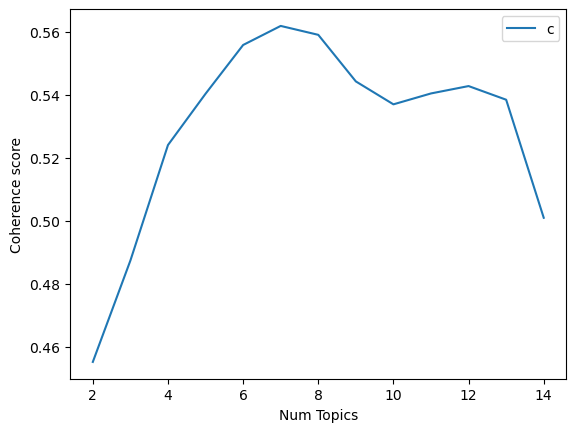

Optimal number of topics: 7
(0, '0.034*"face" + 0.030*"grinning" + 0.030*"sweat" + 0.014*"heart" + 0.013*"much" + 0.010*"together" + 0.010*"palm" + 0.009*"yes" + 0.007*"better" + 0.007*"fiat" + 0.007*"cost" + 0.007*"buy" + 0.007*"one" + 0.007*"let" + 0.007*"boat" + 0.007*"mine" + 0.006*"I" + 0.005*"white" + 0.005*"need" + 0.005*"une" + 0.005*"thought" + 0.005*"eu" + 0.005*"asap" + 0.005*"bien" + 0.005*"alone" + 0.005*"sparkle" + 0.005*"house" + 0.005*"w" + 0.005*"true" + 0.005*"close" + 0.004*"never" + 0.004*"best" + 0.004*"years" + 0.003*"c" + 0.003*"engine" + 0.003*"really" + 0.003*"tan" + 0.003*"e" + 0.003*"que" + 0.003*"colour" + 0.003*"seen" + 0.003*"ah" + 0.003*"vespa" + 0.003*"da" + 0.003*"mean" + 0.003*"getting" + 0.003*"help" + 0.003*"buying" + 0.003*"صح" + 0.003*"permis" + 0.003*"black" + 0.003*"get" + 0.003*"crash" + 0.003*"pues" + 0.003*"pena" + 0.003*"mi" + 0.003*"uno" + 0.003*"bonito" + 0.003*"comprado" + 0.003*"hija" + 0.003*"darselo" + 0.003*"yo" + 0.003*"son" + 0.003*"

In [11]:
import pandas as pd
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load the dataset
file_path = '/Users/federicomartin/Desktop/final_translated_comments_with_text_emojis.csv' 
df = pd.read_csv(file_path)

# Preprocessing: Tokenization and removing stopwords
stop_words = set(stopwords.words('english'))
df['tokens'] = df['translated_comments'].apply(lambda x: [word for word in word_tokenize(str(x)) if word.isalpha() and word not in stop_words])

# Build bigrams and trigrams
bigram = Phrases(df['tokens'], min_count=5, threshold=100)  # Higher threshold fewer phrases.
trigram = Phrases(bigram[df['tokens']], threshold=100)  

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Create trigrams
df['trigrams'] = df['tokens'].apply(lambda x: trigram_mod[bigram_mod[x]])

# Remove unrelated words from trigrams
df['filtered_trigrams'] = df['trigrams'].apply(lambda x: [word for word in x if word not in unrelated_words])

# Create Dictionary and Corpus
id2word = corpora.Dictionary(df['filtered_trigrams'])
corpus = [id2word.doc2bow(text) for text in df['filtered_trigrams']]

# Coherence test for various number of topics
coherence_values = []
model_list = []
topic_range = range(2, 15, 1)
random_seed = 7# Set your random seed here

for num_topics in topic_range:
    model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=random_seed, passes=10)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=df['filtered_trigrams'], dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Plot coherence scores
plt.plot(topic_range, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Select the model with the highest coherence score
optimal_num_topics = topic_range[coherence_values.index(max(coherence_values))]
print(f"Optimal number of topics: {optimal_num_topics}")

# Build the LDA model with the optimal number of topics
optimal_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=optimal_num_topics, random_state=random_seed, passes=10)

# Print the topics with the top 65 words, now filtered
topics = optimal_model.print_topics(num_words=65)
topic_words_df = pd.DataFrame(topics, columns=["Topic", "Top Words"])
output_path = '/Users/federicomartin/Desktop/City/Applied Research Project/TikTok/tiktok_topics_top_50_words.csv'
topic_words_df.to_csv(output_path, index=False)

for topic in topics:
    print(topic)

In [21]:
print(f"Coherence score of optimal number of topics: {coherence_values[topic_range.index(optimal_num_topics)]}")


Coherence score of optimal number of topics: 0.5618890986719557


In [12]:
import pandas as pd

# Assuming you have already built the optimal LDA model as in the provided code.
# We will now extract the document-topic distribution.

# Extract the document-topic distribution for each comment
doc_topic_dist = optimal_model[corpus]

# Convert this distribution into a DataFrame
doc_topic_df = pd.DataFrame()

for i, row_list in enumerate(doc_topic_dist):
    row = [0] * optimal_num_topics
    for topic_num, prop in row_list:
        row[topic_num] = prop
    doc_topic_df = pd.concat([doc_topic_df, pd.Series(row)], axis=1)

doc_topic_df = doc_topic_df.T  # Transpose to get topics as columns
doc_topic_df.columns = [f"Topic_{i+1}" for i in range(optimal_num_topics)]  # Rename columns

# Now, let's save this document-topic distribution for future use
doc_topic_dist_file = 'Zdoc_topic_dist_tiktok_comments.csv'
doc_topic_df.to_csv(doc_topic_dist_file, index=False)

# Define the directory path
directory_path = "/Users/federicomartin/Desktop/City/Applied Research Project/TikTok"

# Function to extract comments for each topic with their weights
def extract_comments_for_topics(doc_topic_df, comments, num_topics, output_prefix, threshold=0.3):
    for topic in range(num_topics):
        # Extract comments and their weights (probabilities) for this topic
        topic_comments_weights = [(comments[i], doc_topic_df.iloc[i, topic]) for i in range(len(comments)) if doc_topic_df.iloc[i, topic] > threshold]

        # Save the comments and their weights to a CSV file
        output_file = f"{directory_path}/{output_prefix}_topic_{topic + 1}_comments.csv"
        pd.DataFrame(topic_comments_weights, columns=["Comment", "Weight"]).to_csv(output_file, index=False)
        print(f"Comments and weights for Topic {topic + 1} saved to {output_file}")

# Extract comments for the identified topics
comments = df['cleaned_comment_original'].tolist()  # Use the original translated comments

extract_comments_for_topics(doc_topic_df, comments, optimal_num_topics, 'tiktok_comments')



Comments and weights for Topic 1 saved to /Users/federicomartin/Desktop/City/Applied Research Project/TikTok/tiktok_comments_topic_1_comments.csv
Comments and weights for Topic 2 saved to /Users/federicomartin/Desktop/City/Applied Research Project/TikTok/tiktok_comments_topic_2_comments.csv
Comments and weights for Topic 3 saved to /Users/federicomartin/Desktop/City/Applied Research Project/TikTok/tiktok_comments_topic_3_comments.csv
Comments and weights for Topic 4 saved to /Users/federicomartin/Desktop/City/Applied Research Project/TikTok/tiktok_comments_topic_4_comments.csv
Comments and weights for Topic 5 saved to /Users/federicomartin/Desktop/City/Applied Research Project/TikTok/tiktok_comments_topic_5_comments.csv
Comments and weights for Topic 6 saved to /Users/federicomartin/Desktop/City/Applied Research Project/TikTok/tiktok_comments_topic_6_comments.csv
Comments and weights for Topic 7 saved to /Users/federicomartin/Desktop/City/Applied Research Project/TikTok/tiktok_comments

In [13]:
import pandas as pd

# Define the directory path where your files are stored
directory_path = "/Users/federicomartin/Desktop/City/Applied Research Project/TikTok"

# List of topics (assuming you have files for each topic)
topics = [1, 2, 3, 4, 5, 6, 7]

for topic_num in topics:
    # Load the comments for the current topic
    topic_df = pd.read_csv(f'{directory_path}/tiktok_comments_topic_{topic_num}_comments.csv')

    # Calculate the mean and standard deviation for the weights
    mean_weight = topic_df['Weight'].mean()
    std_dev = topic_df['Weight'].std()
    
    # Define thresholds based on mean and standard deviation
    most_important_threshold = mean_weight + std_dev
    least_important_threshold = mean_weight - std_dev

    # Categorize the comments based on the thresholds
    most_important_comments = topic_df[topic_df['Weight'] > most_important_threshold]
    important_comments = topic_df[(topic_df['Weight'] <= most_important_threshold) & (topic_df['Weight'] >= least_important_threshold)]
    least_important_comments = topic_df[topic_df['Weight'] < least_important_threshold]

    # Save the categorized comments to CSV files
    most_important_comments.to_csv(f'{directory_path}/TIKTOK most_important_comments_topic_{topic_num}.csv', index=False)
    important_comments.to_csv(f'{directory_path}/TIKTOK important_comments_topic_{topic_num}.csv', index=False)
    least_important_comments.to_csv(f'{directory_path}/TIKTOK least_important_comments_topic_{topic_num}.csv', index=False)

    print(f"Categorized comments for Topic {topic_num} have been saved.")
    


Categorized comments for Topic 1 have been saved.
Categorized comments for Topic 2 have been saved.
Categorized comments for Topic 3 have been saved.
Categorized comments for Topic 4 have been saved.
Categorized comments for Topic 5 have been saved.
Categorized comments for Topic 6 have been saved.
Categorized comments for Topic 7 have been saved.


In [3]:
# pip install transformers[torch]
%pip install Datasets


Note: you may need to restart the kernel to use updated packages.


### Bart model fine tuning 

In [2]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import torch

# Check if MPS is available
device = torch.device("mps") if torch.backends.mps.is_built() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set the Hugging Face model repo
model_name = "suriya7/bart-finetuned-text-summarization"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# Ensure special tokens are set
model.config.decoder_start_token_id = model.config.decoder_start_token_id or tokenizer.bos_token_id
model.config.pad_token_id = model.config.pad_token_id or tokenizer.pad_token_id

# Load the few-shot examples
few_shot_examples_path = "/Users/federicomartin/Desktop/NEW Cleaned_Few_Shot_Example.csv"#### Mention the path here 
few_shot_df = pd.read_csv(few_shot_examples_path)

# Preprocess the dataset
def preprocess_function(examples):
    inputs = tokenizer(examples["Comments"], max_length=1024, truncation=True, padding="max_length")
    targets = tokenizer(examples["Summary"], max_length=150, truncation=True, padding="max_length")
    inputs["labels"] = targets["input_ids"]
    inputs["labels"] = [[label if label != tokenizer.pad_token_id else -100 for label in labels] for labels in inputs["labels"]]  # Ignore padded tokens in the loss computation
    return inputs

# Convert the DataFrame to a Dataset
few_shot_dataset = Dataset.from_pandas(few_shot_df)
tokenized_few_shot_dataset = few_shot_dataset.map(preprocess_function, batched=True)

# Training arguments without evaluation
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="no",  # Disable evaluation
    learning_rate=6e-5,  # 3 best 
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    use_cpu=True,
    num_train_epochs=45,  # Increase epochs due to small dataset 35 best 
    predict_with_generate=True
)

# Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_few_shot_dataset,
    tokenizer=tokenizer
)

# Fine-tune the model
trainer.train()

# Save the trained model and tokenizer
trainer.save_model("./fine-tuned-model")
tokenizer.save_pretrained("./fine-tuned-model")


Using device: mps


Map:   0%|          | 0/15 [00:00<?, ? examples/s]

/Users/federicomartin/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/180 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

{'train_runtime': 2386.662, 'train_samples_per_second': 0.283, 'train_steps_per_second': 0.075, 'train_loss': 0.20181935628255207, 'epoch': 45.0}


('./fine-tuned-model/tokenizer_config.json',
 './fine-tuned-model/special_tokens_map.json',
 './fine-tuned-model/vocab.json',
 './fine-tuned-model/merges.txt',
 './fine-tuned-model/added_tokens.json',
 './fine-tuned-model/tokenizer.json')

### Topic summarization

In [14]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from tqdm import tqdm
from docx import Document

# Define the directory path where your files are stored
directory_path = "/Users/federicomartin/Desktop/City/Applied Research Project/TikTok"

# List of topics (assuming you have files for each topic)
topics = [1, 2, 3, 4, 5, 6, 7]  # Add more topics if needed

# Check if MPS or CUDA is available and set the device accordingly
device = torch.device("mps") if torch.backends.mps.is_built() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the fine-tuned model and tokenizer
model_name = "./fine-tuned-model"  # Path to your fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# Function to generate summaries
def generate_summary(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True, padding="max_length")
    inputs = {key: value.to(device) for key, value in inputs.items()}
    summary_ids = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], num_beams=4, max_length=150, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Initialize the progress bar
total_steps = len(topics) * 3  # Number of topics times 3 categories per topic
progress_bar = tqdm(total=total_steps, desc="Processing")

for topic_num in topics:
    # Load the comments for the current topic
    topic_df = pd.read_csv(f'{directory_path}/tiktok_comments_topic_{topic_num}_comments.csv')

    # Calculate the mean and standard deviation for the weights
    mean_weight = topic_df['Weight'].mean()
    std_dev = topic_df['Weight'].std()
    
    # Define thresholds based on mean and standard deviation
    most_important_threshold = mean_weight + std_dev
    least_important_threshold = mean_weight - std_dev

    # Categorize the comments based on the thresholds
    most_important_comments = topic_df[topic_df['Weight'] > most_important_threshold]
    important_comments = topic_df[(topic_df['Weight'] <= most_important_threshold) & (topic_df['Weight'] >= least_important_threshold)]
    least_important_comments = topic_df[topic_df['Weight'] < least_important_threshold]

    # Save the categorized comments to CSV files
    most_important_comments.to_csv(f'{directory_path}/TIKTOK_most_important_comments_topic_{topic_num}.csv', index=False)
    important_comments.to_csv(f'{directory_path}/TIKTOK_important_comments_topic_{topic_num}.csv', index=False)
    least_important_comments.to_csv(f'{directory_path}/TIKTOK_least_important_comments_topic_{topic_num}.csv', index=False)

    print(f"Categorized comments for Topic {topic_num} have been saved.")
    
    # Create a Word document for the summaries
    document = Document()
    document.add_heading(f'Topic {topic_num}', level=1)
    
    for category, comments_df in zip(
        ['most_important', 'important', 'least_important'], 
        [most_important_comments, important_comments, least_important_comments]
    ):
        # Calculate the number of comments and average weight of each aspect
        num_comments = len(comments_df)
        average_weight = comments_df['Weight'].mean() if num_comments > 0 else 'N/A'
        
        # Ensure all comments are strings and handle NaNs
        comments_df['Comment'] = comments_df['Comment'].fillna('').astype(str)

        # Concatenate all comments in the category
        all_comments = " ".join(comments_df['Comment'].tolist())
        
        # Generate a summary for all comments together
        if all_comments.strip():  # Only generate summary if there are comments
            summary = generate_summary(all_comments)
        else:
            summary = "No comments available."
        
        # Add the summary to the document
        document.add_heading(f'{category.replace("_", " ").title()} Comments Summary', level=2)
        document.add_paragraph(f'Number of comments: {num_comments}')
        document.add_paragraph(f'Average weight: {average_weight}')
        document.add_paragraph(summary)
        
        # Update the progress bar
        progress_bar.update(1)
    
    # Save the document for this topic
    document_path = f'{directory_path}/TIKTOK_Topic_{topic_num}_summaries.docx'
    document.save(document_path)

# Close the progress bar
progress_bar.close()



Using device: mps


Processing:   0%|          | 0/21 [00:00<?, ?it/s]/var/folders/x1/518kd7394j54w55305x5jkpw0000gn/T/ipykernel_7649/1218828593.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Categorized comments for Topic 1 have been saved.


Processing:  14%|█▍        | 3/21 [02:27<14:41, 48.96s/it]/var/folders/x1/518kd7394j54w55305x5jkpw0000gn/T/ipykernel_7649/1218828593.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Categorized comments for Topic 2 have been saved.


Processing:  29%|██▊       | 6/21 [05:02<12:42, 50.86s/it]/var/folders/x1/518kd7394j54w55305x5jkpw0000gn/T/ipykernel_7649/1218828593.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Categorized comments for Topic 3 have been saved.


Processing:  43%|████▎     | 9/21 [07:08<08:48, 44.00s/it]/var/folders/x1/518kd7394j54w55305x5jkpw0000gn/T/ipykernel_7649/1218828593.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Categorized comments for Topic 4 have been saved.


Processing:  57%|█████▋    | 12/21 [09:24<06:36, 44.10s/it]/var/folders/x1/518kd7394j54w55305x5jkpw0000gn/T/ipykernel_7649/1218828593.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Categorized comments for Topic 5 have been saved.


Processing:  71%|███████▏  | 15/21 [11:42<04:31, 45.33s/it]/var/folders/x1/518kd7394j54w55305x5jkpw0000gn/T/ipykernel_7649/1218828593.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Categorized comments for Topic 6 have been saved.


Processing:  86%|████████▌ | 18/21 [13:47<02:07, 42.38s/it]/var/folders/x1/518kd7394j54w55305x5jkpw0000gn/T/ipykernel_7649/1218828593.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Categorized comments for Topic 7 have been saved.


Processing: 100%|██████████| 21/21 [16:16<00:00, 46.50s/it]


### Similarity between tiktok and marketing topics

In [30]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import numpy as np

# Load the topics from both the Instagram topics and marketing topics CSV files
tiktok_topics_df = pd.read_csv('/Users/federicomartin/Desktop/City/Applied Research Project/TikTok/tiktok_topics_top_50_words.csv')
marketing_topics_df = pd.read_csv('/Users/federicomartin/Desktop/City/Applied Research Project/Fiat_Dolcevita_Marketing_Topics_75_words.csv')

# Combine the 'Top Words' from the topics into a list
tiktok_topics = tiktok_topics_df['Top Words'].tolist()
marketing_topics = marketing_topics_df['Top Words'].tolist()

# Assign meaningful labels to the Tiktok topics
tiktok_topic_labels = [
    "Fiat Dolcevita: Design and Reliability",
    "Fiat Dolcevita: Practicality versus Competitive Value",
    "Fiat Dolcevita: Eco-Friendly Appeal and Performance",
    "Fiat Dolcevita: Historical Significance versus Modern Expectations",
    "Fiat Dolcevita: Features",
    "Fiat Dolcevita: Stylish Urban Utility",
    "Fiat Dolcevita: Innovation with Practicality",
]

# Assign meaningful labels to the marketing topics
marketing_topic_labels = [
    "Fiat Marketing: Design and Exterior",
    "Fiat Marketing: Lifestyle Dolce Vita",
    "Fiat Marketing: Driver Assistance and Features",
    "Fiat Marketing: General Features and Design",
    "Fiat Marketing: Advanced Technology",
    "Fiat Marketing: Luxurious Interior and Sustainability",
    # "Fiat Marketing: Fiat Brand and Dolcevita",
    "Fiat Marketing: Touchscreen and Infotainment"
]

# Ensure that the number of labels matches the number of topics
assert len(tiktok_topics) == len(tiktok_topic_labels), "Number of TIKTOK topics and labels do not match"
assert len(marketing_topics) == len(marketing_topic_labels), "Number of marketing topics and labels do not match"

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the topics from both datasets
marketing_tfidf = vectorizer.fit_transform(marketing_topics)
tiktok_tfidf = vectorizer.transform(tiktok_topics)

# Calculate cosine similarity between the TIKTOK topics and marketing topics
similarity_matrix = cosine_similarity(tiktok_tfidf, marketing_tfidf)

# Create an interactive heatmap using plotly
fig = px.imshow(
    similarity_matrix,
    labels=dict(x="Marketing Topics", y="TikTok Topics", color="Cosine Similarity"),
    x=marketing_topic_labels,
    y=tiktok_topic_labels,
    color_continuous_scale=[
        [0.0, 'red'],   # Low overlap
        [0.5, 'yellow'],  # Medium overlap
        [1.0, 'green']    # Strong overlap
    ],
    text_auto=True
)

fig.update_layout(
    title="Similarity Between TikTok and Marketing Topics",
    xaxis_title="Marketing Topics",
    yaxis_title="TikTok Topics",
    width=1000,
    height=800,
    xaxis_tickangle=-45
)

fig.show()


### Sentiment analysis

In [23]:
import pandas as pd
from transformers import pipeline
import torch
import time

# Check if Apple Silicon with MPS backend is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Load your data
file_path =  '/Users/federicomartin/Desktop/final_translated_comments_with_text_emojis.csv'
tiktok_data = pd.read_csv(file_path)

# Load the pre-trained sentiment-analysis pipeline with GPU support
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=device)

# Function to split text into chunks of max_length
def chunk_text(text, max_length=512):
    return [text[i:i + max_length] for i in range(0, len(text), max_length)]

# Function to apply sentiment analysis safely with segment processing
def analyze_sentiment(text):
    try:
        chunks = chunk_text(text, max_length=512)
        sentiments = [sentiment_pipeline(chunk)[0]['label'] for chunk in chunks]
        # Aggregate sentiments (simple approach: take the mode, assuming it's a majority vote)
        aggregated_sentiment = max(set(sentiments), key=sentiments.count)
        return aggregated_sentiment
    except Exception as e:
        print(f"Error processing text: {text}\nError: {e}")
        return None

# Progress tracking variables
total_comments = len(tiktok_data)
start_time = time.time()

# Apply sentiment analysis to the translated comments
sentiments = []
for idx, comment in enumerate(tiktok_data['comment']):
    sentiment = analyze_sentiment(str(comment))
    sentiments.append(sentiment)

    # Print progress every 10 comments
    if (idx + 1) % 10 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {idx + 1}/{total_comments} comments. Elapsed time: {elapsed_time:.2f} seconds.")

# Add sentiments to the dataframe
tiktok_data['sentiment'] = sentiments

# Display the first few rows to show the sentiment analysis results
print(tiktok_data.head())

# Define the directory path
directory_path = "/Users/federicomartin/Desktop/City/Applied Research Project/TikTok"

# Save the results to a new CSV file
output_file_path = f"{directory_path}/sentiment_analyzed_comments_with_text_emojis_tiktok_fiat.csv"
tiktok_data.to_csv(output_file_path, index=False)

print(f"Sentiment analysis complete. Results saved to {output_file_path}.")

Using device: mps


pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/Users/federicomartin/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Processed 10/502 comments. Elapsed time: 12.87 seconds.
Processed 20/502 comments. Elapsed time: 19.94 seconds.
Processed 30/502 comments. Elapsed time: 22.61 seconds.
Processed 40/502 comments. Elapsed time: 25.39 seconds.
Processed 50/502 comments. Elapsed time: 28.25 seconds.
Processed 60/502 comments. Elapsed time: 30.06 seconds.
Processed 70/502 comments. Elapsed time: 33.94 seconds.
Processed 80/502 comments. Elapsed time: 37.20 seconds.
Processed 90/502 comments. Elapsed time: 40.02 seconds.
Processed 100/502 comments. Elapsed time: 40.85 seconds.
Processed 110/502 comments. Elapsed time: 42.60 seconds.
Processed 120/502 comments. Elapsed time: 45.19 seconds.
Processed 130/502 comments. Elapsed time: 46.47 seconds.
Processed 140/502 comments. Elapsed time: 48.30 seconds.
Processed 150/502 comments. Elapsed time: 49.24 seconds.
Processed 160/502 comments. Elapsed time: 49.80 seconds.
Processed 170/502 comments. Elapsed time: 50.50 seconds.
Processed 180/502 comments. Elapsed time

#### Star rating plot

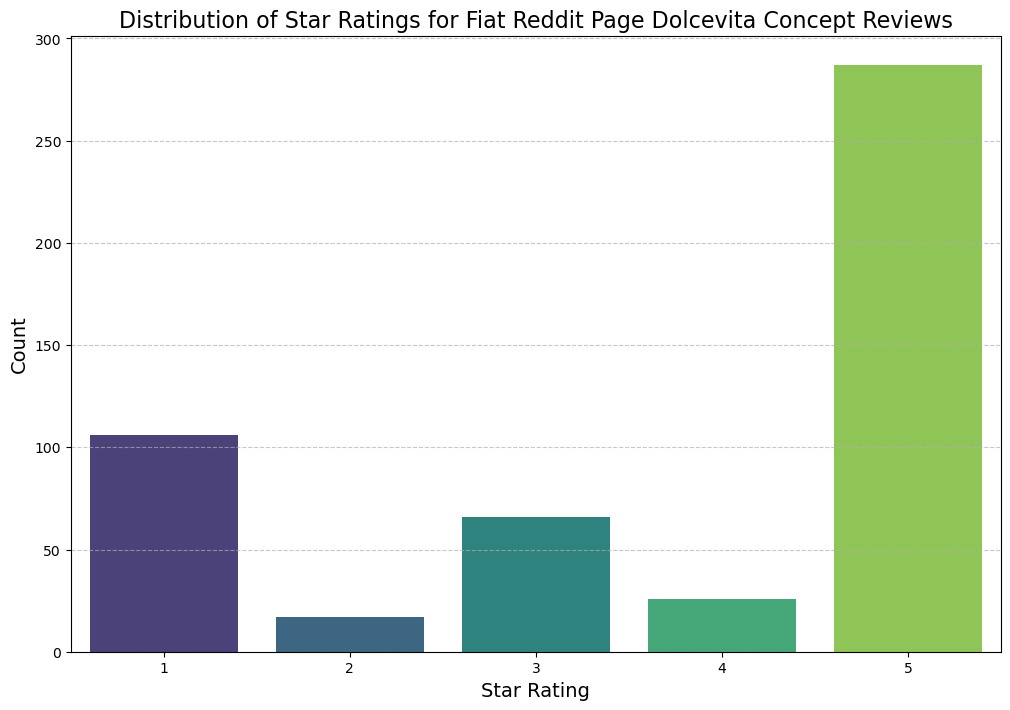

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the sentiment analyzed data
file_path =  '/Users/federicomartin/Desktop/City/Applied Research Project/TikTok/sentiment_analyzed_comments_with_text_emojis_tiktok_fiat.csv'
tiktok_data = pd.read_csv(file_path)

# Extract the star ratings from the sentiment labels
tiktok_data['star_rating'] = tiktok_data['sentiment'].apply(lambda x: int(x.split()[0]) if 'star' in x else None)

# Count the occurrences of each star rating
rating_counts = tiktok_data['star_rating'].value_counts().sort_index(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')

# Set plot details
plt.title('Distribution of Star Ratings for Fiat Reddit Page Dolcevita Concept Reviews', fontsize=16)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save and display the plot
plt.savefig('star_rating_distribution_with_text_emojis_fiat_Reddit.png', dpi=300)
plt.show()

#### Sentiment distribution

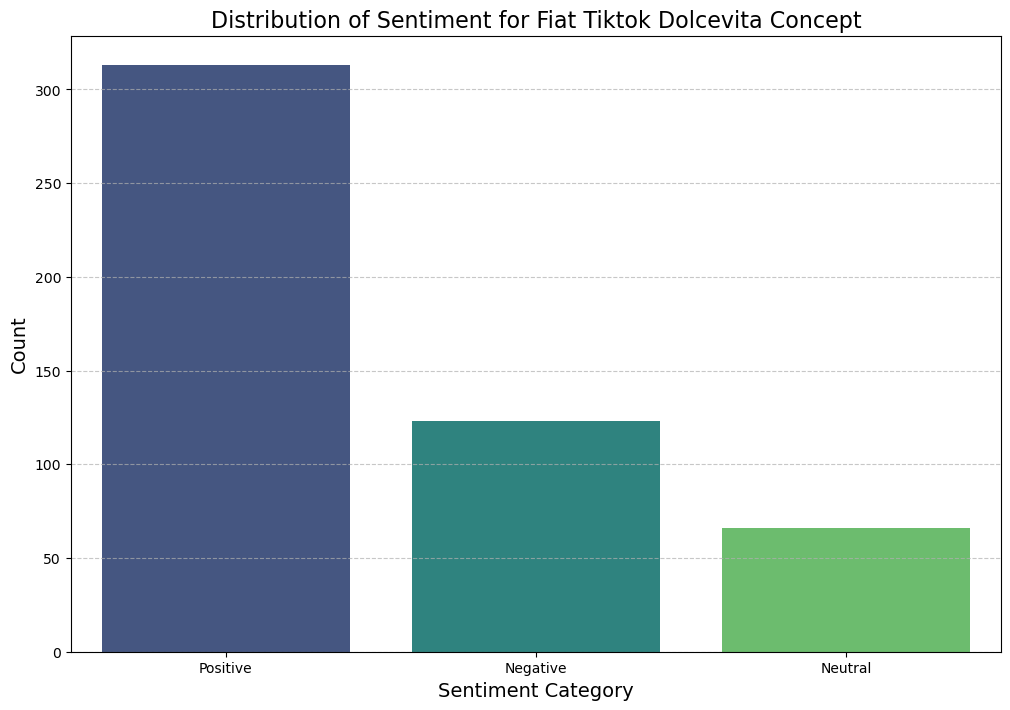

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the sentiment analyzed data
file_path =  '/Users/federicomartin/Desktop/City/Applied Research Project/TikTok/sentiment_analyzed_comments_with_text_emojis_tiktok_fiat.csv'
tiktok_data = pd.read_csv(file_path)

# Extract the star ratings from the sentiment labels
tiktok_data['star_rating'] = tiktok_data['sentiment'].apply(lambda x: int(x.split()[0]) if 'star' in x else None)

# Convert star ratings to sentiment categories
def star_to_sentiment(star_rating):
    if star_rating in [4, 5]:
        return 'Positive'
    elif star_rating == 3:
        return 'Neutral'
    elif star_rating in [1, 2]:
        return 'Negative'
    else:
        return None

tiktok_data['sentiment_category'] = tiktok_data['star_rating'].apply(star_to_sentiment)

# Count the occurrences of each sentiment category
sentiment_counts = tiktok_data['sentiment_category'].value_counts()

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

# Set plot details
plt.title('Distribution of Sentiment for Fiat Tiktok Dolcevita Concept', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save and display the plot
plt.savefig('sentiment_category_distribution_fiat_Tiktok.png', dpi=300)
plt.show()